In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=293376 sha256=bfa315b3b7e61ce48f7b86ba0193ccca3b12c433a085e65ac43de71e15004dde
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_33/1060525411.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Signal'][5:] = np.where(df['MA5'][5:] > df['MA22'][5:], 1, 0)
/tmp/ipykernel_33/106052

Genel Bilgiler:
Gün sayısı: 1105 gün
Sinyale göre işlem sayısı: 666
Karlı kapatan gün sayısı: 348
Zararlı kapatan gün sayısı: 203
En uzun ardışık kâr günleri: 8 gün
En uzun ardışık zarar günleri: 6 gün
En karlı işlem tarihi: 2020-12-08 00:00:00, Kar: 0.10245893111370408
En zararlı işlem tarihi: 2023-02-15 00:00:00, Zarar: -0.15937158475569824


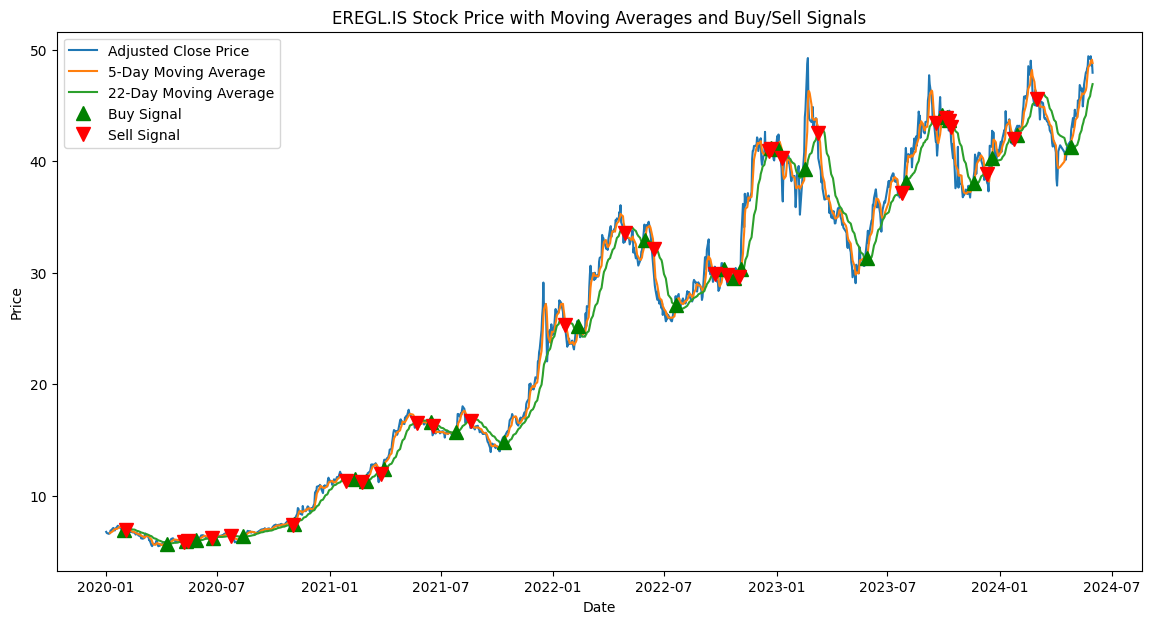

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


df = yf.download("EREGL.IS", start='2020-01-01', end='2024-06-01')


df["MA5"] = df['Adj Close'].rolling(window=5).mean()
df["MA22"] = df['Adj Close'].rolling(window=22).mean()

df['Signal'] = 0
df['Signal'][5:] = np.where(df['MA5'][5:] > df['MA22'][5:], 1, 0)
df['Position'] = df['Signal'].diff()


df["returns"] = df["Adj Close"].pct_change()

df["profit"] = df["returns"] * df['Signal']
df["loss"] = -df["returns"] * (1 - df['Signal'])


df["cum_profit"] = df["profit"].cumsum()
df["cum_loss"] = df["loss"].cumsum()


df["kasa"] = df["cum_profit"] + df["cum_loss"]


zararda_oturulan_gun_sayisi = df[df["loss"] < 0].shape[0]

karli_islemler = df[df["profit"] > 0]["profit"].count()


zararli_islemler = df[df["loss"] < 0]["loss"].count()

karli_kapanan_gun_sayisi = df[df["profit"] > 0].shape[0]

zararli_kapanan_gun_sayisi = df[df["loss"] < 0].shape[0]

ardisik_kar_gunler = df[df['profit'] > 0]['profit'].groupby((df['profit'] <= 0).cumsum()).count()
ardisik_zarar_gunler = df[df['loss'] < 0]['loss'].groupby((df['loss'] >= 0).cumsum()).count()

en_uzun_ardisik_kar_gunleri = ardisik_kar_gunler.max() if not ardisik_kar_gunler.empty else 0
en_uzun_ardisik_zarar_gunleri = ardisik_zarar_gunler.max() if not ardisik_zarar_gunler.empty else 0


en_karli_islem = df[df["profit"] == df["profit"].max()]
en_zararli_islem = df[df["loss"] == df["loss"].min()]

en_karli_tarih = en_karli_islem.index[0]
en_zararli_tarih = en_zararli_islem.index[0]

en_karli_kar = en_karli_islem["profit"].values[0]
en_zararli_zarar = en_zararli_islem["loss"].values[0]

en_karli_fiyat = df['Adj Close'][en_karli_tarih]
en_zararli_fiyat = df['Adj Close'][en_zararli_tarih]

print("Genel Bilgiler:")
print(f"Gün sayısı: {len(df)} gün")
print(f"Sinyale göre işlem sayısı: {df['Signal'].sum()}")
print(f"Karlı kapatan gün sayısı: {karli_kapanan_gun_sayisi}")
print(f"Zararlı kapatan gün sayısı: {zararli_kapanan_gun_sayisi}")
print(f"En uzun ardışık kâr günleri: {en_uzun_ardisik_kar_gunleri} gün")
print(f"En uzun ardışık zarar günleri: {en_uzun_ardisik_zarar_gunleri} gün")
print(f"En karlı işlem tarihi: {en_karli_tarih}, Kar: {en_karli_kar}")
print(f"En zararlı işlem tarihi: {en_zararli_tarih}, Zarar: {en_zararli_zarar}")


plt.figure(figsize=(14,7))
plt.plot(df['Adj Close'], label='Adjusted Close Price')
plt.plot(df['MA5'], label='5-Day Moving Average')
plt.plot(df['MA22'], label='22-Day Moving Average')
plt.plot(df[df['Position'] == 1].index, 
         df['MA5'][df['Position'] == 1],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df[df['Position'] == -1].index, 
         df['MA5'][df['Position'] == -1],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('EREGL.IS Stock Price with Moving Averages and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
